In [1]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-5bpbk58h
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-5bpbk58h
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33785 sha256=0c80e8529f565e71e163ca2d5c1f570271aa0fd54acdfce8b2fd1e99302f60b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ijrt6pgg/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation_models


In [2]:
import tensorflow as tf
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import glob
import cv2
import numpy as np 
from matplotlib import pyplot as plt

2024-04-06 05:06:56.150283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 05:06:56.150378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 05:06:56.323940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [3]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
SIZE_X = 256
SIZE_Y = 256

In [4]:
train_images = []
dataset_path = "../input"  # Thay "image-dataset" bằng tên thư mục dataset thực tế

# Lặp qua các thư mục trong dataset
for directory_path in glob.glob(os.path.join(dataset_path, "image-dataset")):
    # Lặp qua các tệp hình ảnh trong mỗi thư mục
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE_X,SIZE_Y))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        train_images.append(img)
train_images = np.array(train_images)
print("Images in folder:",len(train_images))
# for directory_path in glob.glob("kaggle/input/image-dataset"):
#     for img_path in glob.glob(os.path.join(directory_path,"*.png")):
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         train_images.append(img)


Images in folder: 196


In [5]:
train_masks = []
dataset_path = "../input"  # Thay "image-dataset" bằng tên thư mục dataset thực tế

# Lặp qua các thư mục trong dataset
for directory_path in glob.glob(os.path.join(dataset_path, "masks-dataset")):
    # Lặp qua các tệp hình ảnh trong mỗi thư mục
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(SIZE_X,SIZE_Y))
        mask[mask <=50] = 0
        mask[mask > 50] = 1
        train_masks.append(mask)
train_masks = np.array(train_masks)
print("Masks in folder:",len(train_masks))

Masks in folder: 196


In [6]:
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3)

print(X.shape)
print(X.dtype)
print(Y.shape)
print(Y.dtype)

(196, 256, 256, 3)
uint8
(196, 256, 256, 1)
uint8


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.1,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.1,random_state=42)

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(158, 256, 256, 3)
uint8
(20, 256, 256, 3)
uint8
(18, 256, 256, 3)
uint8


In [9]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
# y_train = y_train.astype('float32')
# y_val = y_val.astype('float32')

In [10]:
# from segmentation_models.losses import bce_jaccard_loss
# from segmentation_models.metrics import iou_score

In [11]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
# model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')
# model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])


85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None


In [13]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss",patience=5,verbose=1)
]

In [14]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size=32,
    epochs=50,
    verbose=1,
    validation_data = (x_val, y_val),
)

Epoch 1/50


I0000 00:00:1712380141.904608     170 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 190s 23s/step - accuracy: 0.1681 - loss: 1.0270 - val_accuracy: 0.0400 - val_loss: 40.9194
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.7200 - loss: 0.6421 - val_accuracy: 0.0373 - val_loss: 80.7519
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.9478 - loss: 0.5350 - val_accuracy: 0.0336 - val_loss: 112.2424
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.9547 - loss: 0.4257 - val_accuracy: 0.0341 - val_loss: 508.7338
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.9545 - loss: 0.3591 - val_accuracy: 0.0338 - val_loss: 109.3445
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - accuracy: 0.9567 - loss: 0.3166 - val_accuracy: 0.0924 - val_loss: 39.9657
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.9599 - loss: 0.2827 - val_accuracy: 0.1957 - val_loss: 559.5298
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.9648 - loss: 0.2537 - val_accuracy: 0.3324 - val_loss:

In [15]:
# In ra độ chính xác của mô hình trên tập huấn luyện và tập xác thực
print("Accuracy on training set: ", max(history.history['accuracy']))
print("Accuracy on validation set: ", max(history.history['val_accuracy']))

Accuracy on training set:  0.9966131448745728
Accuracy on validation set:  0.9900376796722412


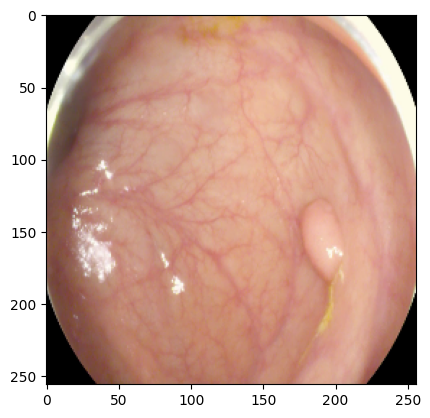

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [16]:
index = np.random.choice(x_test.shape[0])
test_img = x_test[index]
plt.imshow(test_img, cmap='gray')
plt.show()
test_img = np.expand_dims(test_img, axis=0)
prediction = model.predict(test_img)

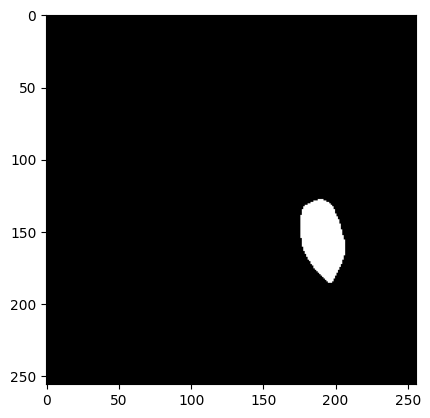

In [17]:
test_mask = y_test[index]
plt.imshow(test_mask, cmap='gray')
plt.show()

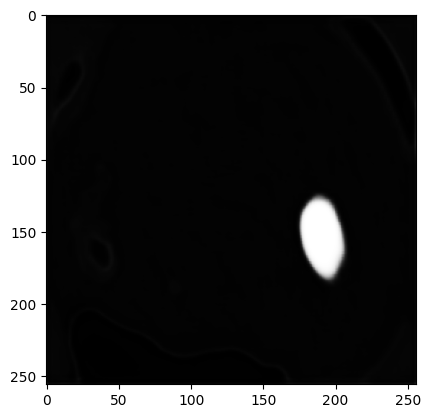

In [18]:
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')

In [19]:
# from tensorflow import keras
# model = keras.models.load_model('/kaggle/working/membrane3000.h5', compile=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


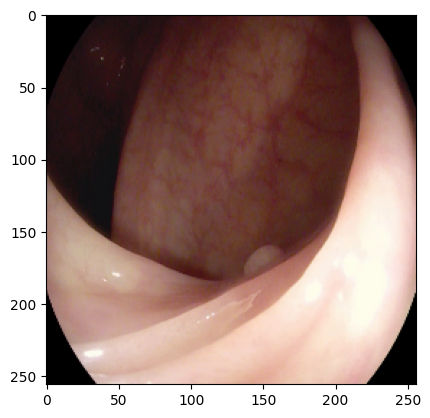

In [20]:
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('../input/image-dataset/169.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

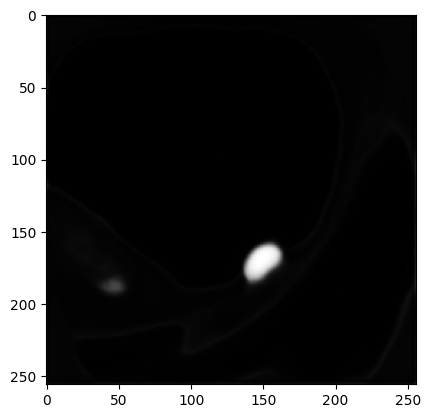

In [21]:
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')

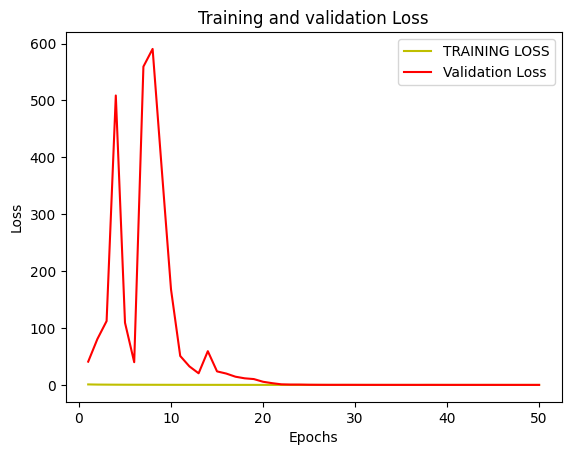

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs,loss,'y',label='TRAINING LOSS')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

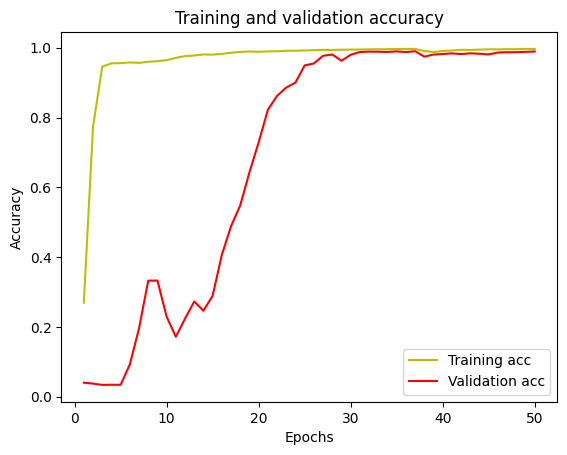

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc,'y', label = "Training acc")
plt.plot(epochs, val_acc, "r", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.show()
